** Detecting the presence of the brachial plexus in ultrasound images of the neck.**
The approach developed in this project is inspired by the work "Ultrasound Nerve Segmentation of Brachial
Plexus Based on Optimized ResU-Net" and involves revealing the presence of the brachial plexus in
ultrasound images of the neck.
The available dataset possesses a limited number of images. Therefore, a fine-tuning strategy was adopted,
which consists of training a network by exploiting networks already trained for another problem and on
another dataset, having a larger size than the one available.

In [ ]:
#!pip install tifffile imagecodecs per le immagini tif
!pip install --upgrade pycocotools git+https://github.com/davin11/keras-cv.git #scarico keras cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/davin11/keras-cv.git to /tmp/pip-req-build-prgbluhn
  Running command git clone --filter=blob:none --quiet https://github.com/davin11/keras-cv.git /tmp/pip-req-build-prgbluhn
  Resolved https://github.com/davin11/keras-cv.git to commit c5f3dfdea58b5c61a483dd8220e33eef5b0541de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for keras-cv: filename=keras_cv-0.5.0-py3-none-any.whl size=733872 sha256=c9085f38aa21e1b6d6d35d51f8ad8f463a9d052ba4b140822d35357a0bb9b7d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-aabyi17s/wheels/c6/24/1b/8f18f031f8fdae5a214b9fbba0a61306519716694aded9265e
Successfully built keras-cv


In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from tensorflow import keras

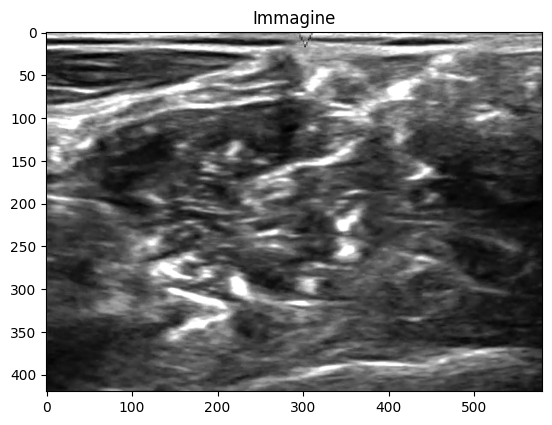

In [ ]:
# Lettura e visualizzazione
def read_img(index1, index2):
  filename_img = '/content/drive/MyDrive/train/%d_%d.png'%(index1,index2)
  #filename_msk = '/content/drive/MyDrive/train/%d_%d_mask.tif'%(index1,index2)

  img = np.float32(io.imread(filename_img))
  #msk = np.float32(io.imread(filename_msk))

  #return img, msk
  return img

index1 = 20
index2 = 38
#img, msk = read_img(index1, index2)
img = read_img(index1,index2)

plt.figure()
plt.imshow(img, cmap='gray', clim=[0,255])
plt.title('Immagine')
plt.show()

In [ ]:
import pandas as pd

tab_train = pd.read_csv('/content/drive/MyDrive/tab_train.csv')
tab_valid = pd.read_csv('/content/drive/MyDrive/tab_test.csv')
tab_test = pd.read_csv('/content/drive/MyDrive/tab_valid.csv')

In [ ]:
# Preparazione dei dati
import keras_cv.utils.image_dataset as image_dataset

batch_size = 32
img_height, img_width = 320, 320

# Data augmentation
from keras_cv.layers.preprocessing import RandomBrightness, RandomAffineTransf
augmenter = keras.Sequential(layers=[
  RandomBrightness(factor=(-0.1, 0.1), value_range=(0, 255)),
  RandomAffineTransf(zoom_range=(0.9,1.1), rotation_range=(-45,45),
                     horizontal_flip=True, vertical_flip=True,
                     width_shift_range=16.0, height_shift_range=16.0)
])

from keras_cv.layers.preprocessing import Resizing
train_dataset = image_dataset.image_classification_dataset_from_dataframe(
  tab_train, root_path='/content/drive/MyDrive/', batch_size=batch_size, shuffle=True,
  pre_batching_processing=Resizing(img_height, img_width),
  post_batching_processing=augmenter,
  include_rescaling=True,
  class_mode='categorical')

valid_dataset = image_dataset.image_classification_dataset_from_dataframe(
  tab_valid, root_path='/content/drive/MyDrive/', batch_size=batch_size, shuffle=True,
  pre_batching_processing=Resizing(img_height, img_width),
  post_batching_processing=augmenter,
  include_rescaling=True,
  class_mode='categorical')

test_dataset = image_dataset.image_classification_dataset_from_dataframe(
  tab_test, root_path='/content/drive/MyDrive/', batch_size=batch_size, shuffle=False,
  pre_batching_processing=Resizing(img_height, img_width),
  post_batching_processing=None,
  include_rescaling=True,
  class_mode='categorical')


For class 'False', there are 2402 images.
For class 'True', there are 1555 images.
shuffling with buffer_size 320


For class 'False', there are 442 images.
For class 'True', there are 397 images.


shuffling with buffer_size 320
For class 'False', there are 468 images.
For class 'True', there are 371 images.


forniamo tabella data prima, in che gruppi raggruppare le immagini, shuffle: a fine di ogni epoca le immagini vengono mischiate per introdurre variabilità, poi prima di creare il batch creare faccioresize per impostare le immagini alle stesse dimensioni, poi dopo fatto il batch non fare nulla
e il parametro di rescale per l' ampiezza le immagini nel range da 0 a 255 vengono convertite da 0 a 1 ,e infine il calss mode categorical le immagini sono convertite in formato one hot.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definizione della rete
base_model = keras.applications.Xception(weights='imagenet', include_top=False,
input_shape=(img_width, img_height, 3))
#include_top=False il fully conncted di imagenet ha mille uscite e a noi servono solo
#2 quindi non prendiamo la parte finale della rete e tralsciamo alnche il global avarage poooling che poi va rimesso


from tensorflow.keras import layers #importa i livelli prefatti:convoluzionali
#from GlobalLSEPooling import GlobalLSEPooling2D

model = keras.models.Sequential() #crea una rete completamente vuota
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(2, activation='softmax')) #aggiungo 1 fully connected con sole 2 uscite, softmax perché vogliamo le probabilità
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Addestramento

train_after_layer = 25 # numero di livelli da congelare
for layer in base_model.layers[:train_after_layer]: #dal modello base prendo i livelli
  layer.trainable = False #non devono essere addestrati
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 20,620,234
Non-trainable params: 245,344
_________________________________________________________________


In [ ]:
learning_rate = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
              metrics=['accuracy', ]) #. adam che utilizza una stima adattiva del primo e del secondo momento del gradiente,
              #con l'approccio NAG, che introduce un termine di momentum per accelerare la convergenza e uno smoothing del gradiente.

In [ ]:
from keras_cv.layers.preprocessing import Resizing
#help(image_dataset.image_classification_dataset_from_dataframe)

In [ ]:
num_epochs = 100

checkpoint_filepath = '/content/drive/MyDrive/checkpoint.{epoch:d}-{val_accuracy:.3f}___'+f'{train_after_layer}-{batch_size}-{learning_rate}.hdf5' # salvataggio dei migliori pesi salvando epoca e accuracy a 3 cifre

#salvo i migliori pesi ottenuti
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy', #monitora accuracy sul validation set
    mode='max', #prende il massimo
    save_best_only=True, #salva solo i pesi migliori
    )

In [ ]:
#model.fit(train_dataset, validation_data=valid_dataset,
          #epochs=num_epochs, verbose=True, callbacks=[model_checkpoint_callback])

IndentationError: ignored

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoint.44-0.708___25-32-1e-05.hdf5')

In [ ]:
# Valutazioni le prestazioni sul test

test_loss, test_accuracy = model.evaluate(test_dataset)
print('test_loss:',test_loss)
print('test_accuracy:',test_accuracy)

27/27 [==============================] - 107s 3s/step - loss: 0.5243 - accuracy: 0.7604
test_loss: 0.5242782235145569
test_accuracy: 0.7604290843009949


In [ ]:
#Usiamo la funzione PREDICT per avere la predizione su tutte le img del dataset di test
#pred è una matrice in formato one-hot con n° righe = n° img test set (839), n° colonne = 2 (prob assegnate alle 2 classi)

pred = model.predict(test_dataset)  #classe predetta


# Per conoscere, non la probabilità, ma la classe che è stata assegnata all'immagine in ingresso, dobbiamo, dato il vettore delle probabilità,
# capire qual è l'indice della probabilità massima

class_pred = np.argmax(pred, 1)   # np.argmax restituisce l'indice del valore  max
                                  # 1 = asse lungo cui fare i confronti


27/27 [==============================] - 13s 418ms/step


In [ ]:
# Otteniamo la classe reale assegnata alle immagini di test.
# Per farlo dobbiamo leggere nella tab_test il valore associato ad ogni img nella colonna "class" della tabella

class_mapping = {True: 1, False: 0}     #Dizionario di mapping
                                        #ho def una struttura di dati contenente 2 coppie chiave/valore, associate al class_mapping
                                        #Al bool True associo il valore 1; al bool False associo il valore 0
                                        #(tab_test['class'][i]) è di tipo bool -> True e False non li scrivo tra apici xk non sono stringhe

class_true = list()   #class_true = lista contenente la classe vera


for i in range(len(tab_test)):                             #scorro la tutte le img di test (tab_test)
  class_true.append(class_mapping[tab_test['class'][i]])   #leggo il contenuto della colonna 'class' con indice i della tab_test
                                                           #'class' contiene True o False, quindi con (class_mapping[tab_test['class'][i]])
                                                           #sto associando il valore 1 alla chiave True e il valore 0 alla chiave False
print(class_true)                                          #alla fine del ciclo for ottengo una lista y_true che contiene le classi assegnate alle img di test



#Un DIZIONARIO è un tipo di dato di Python
#I dizionari sono simili al tipo di dato lista, ma a differenza di queste, in cui ad ogni elemento corrisponde un indice progressivo quindi da 0 in su,
#nei dizionari ad ogni elemento è associata una chiave, che potrà essere usata per accedere al valore dell'elemento.
#Per ogni elemento all'interno del dizionario avremo quindi una coppia chiave/valore.
#I dizionari di Python vengono definiti utilizzando una coppia di parentesi graffe che contenga al suo interno delle coppie chiave/valore separate da due punti

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 

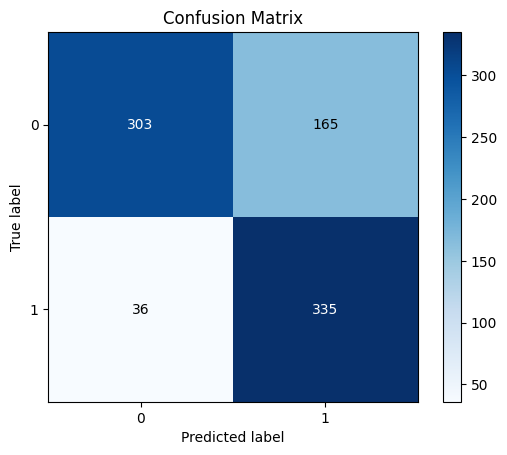

In [ ]:
##### MATRICE DI CONFUSIONE #####

!pip -q install scikit-plot

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(class_true, class_pred)   #class_true = etichetta reale; class_pred = etichetta predetta
plt.show()



#from sklearn.metrics import confusion_matrix
#print('Confusion Matrix')
#print(confusion_matrix(classe, y_pred))

In [ ]:
type(tab_test['class'][i])

numpy.bool_

In [ ]:
%whos

Variable                    Type                  Data/Info
-----------------------------------------------------------
RandomAffineTransf          type                  <class 'keras_cv.layers.p<...>ansf.RandomAffineTransf'>
RandomBrightness            type                  <class 'keras_cv.layers.p<...>htness.RandomBrightness'>
Resizing                    type                  <class 'keras_cv.layers.p<...>ssing.resizing.Resizing'>
augmenter                   Sequential            <keras.engine.sequential.<...>object at 0x7ff5d8569090>
base_model                  Functional            <keras.engine.functional.<...>object at 0x7ff54a41cc70>
batch_size                  int                   32
checkpoint_filepath         str                   /content/drive/MyDrive/ch<...>y:.3f}___25-32-1e-05.hdf5
class_mapping               dict                  n=2
class_pred                  ndarray               839: 839 elems, type `int64`, 6712 bytes
class_true                  list              